In [11]:
import os,sys
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
import matplotlib.pyplot as plt
sys.path.append('../LIB/')
from env import ENV
from sklearn.preprocessing import normalize
from tqdm import tqdm
import pickle
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
import gc

print_to_file = False 
test_run = False 

# train = pd.read_pickle(ENV.lightgbm_train_764.value)
train = pd.read_pickle(ENV.lgb_train_0827.value)
print('train shape is: {}'.format(train.shape))
# test = pd.read_pickle(ENV.lightgbm_test_764.value)
test = pd.read_pickle(ENV.lgb_test_0827.value)
print('test shape is: {}'.format(test.shape))
fe_id = 'comb_764'

train shape is: (307511, 409)
test shape is: (48744, 408)


In [12]:
train['SK_ID_CURR'] = train['SK_ID_CURR'].astype(int)
test['SK_ID_CURR'] = test['SK_ID_CURR'].astype(int)
targets = train.TARGET.values

In [13]:
train_id = train['SK_ID_CURR']
test_id = test['SK_ID_CURR']

# main func

In [14]:
from sklearn.model_selection import train_test_split

def get_time(timezone='America/New_York', time_format='%Y-%m-%d %H:%M:%S'):
    from datetime import datetime
    from dateutil import tz

    # METHOD 1: Hardcode zones:
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz(timezone)

    utc = datetime.utcnow()

    # Tell the datetime object that it's in UTC time zone since 
    # datetime objects are 'naive' by default
    utc = utc.replace(tzinfo=from_zone)

    # Convert time zone
    est = utc.astimezone(to_zone)

    return est.strftime(time_format)

import sys, time
class Logger(object):
    def __init__(self, logtofile=True, logfilename='log'):
        self.terminal = sys.stdout
        self.logfile = "{}_{}.log".format(logfilename, int(time.time()))
        self.logtofile = logtofile

    def write(self, message):
        #         self.terminal.write(message)
        if self.logtofile:
            self.log = open(self.logfile, "a")
            self.log.write('[' + get_time() + '] ' + message)
            self.log.close()

    def flush(self):
        # this flush method is needed for python 3 compatibility.
        # this handles the flush command by doing nothing.
        # you might want to specify some extra behavior here.
        pass


def divert_printout_to_file():
    sys.stdout = Logger(logfilename='logfile')

if print_to_file:
    divert_printout_to_file()  # note: comment this to use pdb

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, train_df, test_df, holdout, num_folds, submission_file_name, fe_img_name, stratified = False, debug= False, colsample=0.67, max_depth=8, num_leaves=31, min_child_samples=20, subsample=0.7, reg_lambda=0.3, lr=0.04, seed=1001, verbose=100, rounds=None):
    print(train_df.shape, test_df.shape, holdout.shape)
    print('MEAN: train({}) vs holdout({}): '.format(len(train_df), len(holdout)), train_df['TARGET'].mean(), holdout['TARGET'].mean())
    # Divide in training/validation and test data
    if df is not None:
        train_df = df[df['TARGET'].notnull()]
        test_df = df[df['TARGET'].isnull()]
        print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
        del df
        gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=seed)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=seed)
        
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    holdout_final_preds = np.zeros(holdout.shape[0])
    feature_importance_df = pd.DataFrame()
    feature_importance_gain_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_scores = []
    holdout_scores = []
    scores = []
    actual_y = []
    pred_y = []
    diff_val_holdout = []
    SK_ID_CURR = []
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
#         print('valid index : ',list(valid_idx)[:5])
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
#         print('MEAN: train({}) vs valid({}): '.format(len(train_y), len(valid_y)), np.mean(train_y), np.mean(valid_y))
        SK_ID_CURR.extend(train_df['SK_ID_CURR'].iloc[valid_idx])
        clf = LGBMClassifier(
            nthread=18,
            n_estimators=30000,
            learning_rate=lr,
            num_leaves=num_leaves,
            colsample_bytree=colsample, # 0.67
            subsample=subsample,
            subsample_freq=0, ## disable subsampling
            max_depth=max_depth,
            reg_alpha=0.65,
            reg_lambda=reg_lambda,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            min_child_samples=min_child_samples,
            silent=-1,
            verbose=-1, )
        if rounds is not None:
            clf.n_estimators = rounds
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose=verbose)
            oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
            sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits
            holdout_preds = clf.predict_proba(holdout[feats])[:, 1] 
        else:
            clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose=verbose, early_stopping_rounds= 200)
            oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
            sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
            holdout_preds = clf.predict_proba(holdout[feats], num_iteration=clf.best_iteration_)[:, 1] 
            
        holdout_final_preds += holdout_preds / folds.n_splits
        score = roc_auc_score(valid_y, oof_preds[valid_idx])
        train_score = clf.best_score_['training']['auc']
        holdout_score = roc_auc_score(holdout['TARGET'], holdout_preds)
        diff = abs(score - holdout_score)
        actual_y.extend(list(valid_y))
        pred_y.extend(list(oof_preds[valid_idx]))
        best_rounds = rounds if rounds is not None else clf.best_iteration_
        print('Fold %2d [%5d] AUC : ho: %.6f / te: %.6f / tr: %.6f (diff: %.6f)' % (n_fold + 1, best_rounds, holdout_score, score,  train_score, diff))
        scores.append(score)
        train_scores.append(train_score)
        holdout_scores.append(holdout_score)
        diff_val_holdout.append(diff)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        fold_importance_gain_df = pd.DataFrame()
        fold_importance_gain_df["feature"] = feats
        fold_importance_gain_df["importance"] = clf.booster_.feature_importance(importance_type='gain')
        fold_importance_gain_df["fold"] = n_fold + 1
        feature_importance_gain_df = pd.concat([feature_importance_gain_df, fold_importance_gain_df], axis=0)
        
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
    holdout_roc = roc_auc_score(holdout['TARGET'], holdout_final_preds)
    holdout_mean = np.mean(holdout_scores)
    full_te_mean = np.mean(scores)
    full_tr_mean = np.mean(train_scores)
    predsAndActual = pd.DataFrame()
    predsAndActual['preds'] = pred_y
    predsAndActual['label'] = actual_y
    predsAndActual['SK_ID_CURR'] = SK_ID_CURR
    predsAndActual.to_pickle('{}_oof.pkl'.format(submission_file_name))
#     print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    print('Full HO score %.6f' % holdout_roc)
    print('FULL HO mean {:.6f}, std {:.6f}'.format(holdout_mean, np.std(holdout_scores)))
    print('FULL TE mean {:.6f}, std {:.6f}'.format(full_te_mean, np.std(scores)))
    print('FULL TR mean {:.6f}, std {:.6f}'.format(full_tr_mean, np.std(train_scores)))
    print('FULL DIFF mean {:.6f}, std {:.6f}'.format(np.mean(diff_val_holdout), np.std(diff_val_holdout)))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        print(submission_file_name)
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
#     if not print_to_file:
#         display_importances(feature_importance_df, fe_img_name)
    feature_importance_df = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    feature_importance_gain_df = feature_importance_gain_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    return feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds 

# Display/plot feature importance
def display_importances(feature_importance_df_, fe_img_name):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(fe_img_name+'.png')


def convert_and_save_imp_df(fe_imp_df, dumpfilename):
    fe_imp_df_mean = fe_imp_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index()
    pickle.dump(fe_imp_df_mean, open(dumpfilename,'wb'))

In [15]:
def runlgb(train, test, holdout):
    colsamples = [0.07]#[0.1,0.15,0.2]#[0.03,0.04,0.05,0.06,0.07,0.08]
    seeds = [20]#[300,4000,50000,600000,7000000,80000000,523445,31275479] # 20
    depth = [5]
    leaves = [16]
    min_child_sam = [20]#, 800]
    subsamples = [1]#0.8, 0.7, 0.6, 0.5, 0.4] # was 1
    reg_lambdas = [0.5]
    # lrs = lrs.tolist()
    lrs2 = [0.05]
    nfolds = 5
    rounds = [None] #[1000]#, 1300, 1600, 1900, 2200, 2500]
    for seed in seeds:
        for colsample in colsamples:
            for d in depth:
                for l in leaves:
                    for mcs in min_child_sam:
                        for subsample in subsamples:
                            for reg_lambda in reg_lambdas:
                                for lr in lrs2:
                                    for r in rounds:
                                        filename = 'fe_936_col{}_lr{}_n{}'.format(len(train.columns), lr, nfolds)
                                        print('#############################################')
                                        print(colsample, seed, d, l, mcs, subsample, reg_lambda, lr, 'nfolds:', nfolds)
                                        print('#############################################')
                                        numfeats = len(train.columns)
                                        with timer("Run LightGBM with kfold"):
                                            return kfold_lightgbm(None, train, test, holdout, nfolds, filename+'.csv', filename, colsample=colsample, verbose=None, max_depth=d, num_leaves=l, min_child_samples=mcs, subsample=subsample, reg_lambda=reg_lambda, lr=lr, seed=seed, stratified=True, rounds=r,debug=True)
    #                                         

In [16]:
# sure_drop = pickle.load(open('../../data/add_features/dropping0824_list','rb'))
sure_drop = []

In [17]:
drop_columns = ['NAME_EDUCATION_TYPE_CODE_GENDER_AMT_CREDIT_mean_abs_diff',
                'inst_DAYS_INSTALMENT_std',]
drop_columns = []
#                 'bureau_onehot_CREDIT_TYPE_Microloan', 'BURO_STATUS_0_MEAN_MEAN']

drop_columns = list(set(sure_drop + drop_columns))
train = train.drop(drop_columns,axis=1)
print(train.shape)
test = test.drop(drop_columns,axis=1)
print(test.shape)

(307511, 409)
(48744, 408)


In [18]:
train_drop = train.copy()
test_drop = test.copy()

In [19]:
train_df, holdout = train_test_split(train_drop, test_size=1/10000, random_state=99)
print('MEAN: train({}) vs holdout({}): '.format(len(train_df), len(holdout)), train_df['TARGET'].mean(), holdout['TARGET'].mean())
print(train_df.shape, test_drop.shape, holdout.shape)

MEAN: train(307480) vs holdout(31):  0.08072720176922077 0.0967741935483871
(307480, 409) (48744, 408) (31, 409)


# Experiment

In [20]:
#1165
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_drop, test_drop, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(307511, 409) (48744, 408) (31, 409)
MEAN: train(307511) vs holdout(31):  0.08072881945686496 0.0967741935483871
Fold  1 [ 1224] AUC : ho: 0.785714 / te: 0.794278 / tr: 0.864321 (diff: 0.008564)
Fold  2 [ 1113] AUC : ho: 0.738095 / te: 0.795867 / tr: 0.860290 (diff: 0.057771)
Fold  3 [ 1529] AUC : ho: 0.785714 / te: 0.798267 / tr: 0.876580 (diff: 0.012553)
Fold  4 [ 1188] AUC : ho: 0.797619 / te: 0.796349 / tr: 0.863602 (diff: 0.001270)
Fold  5 [ 1192] AUC : ho: 0.726190 / te: 0.799275 / tr: 0.862634 (diff: 0.073084)
Full HO score 0.773810
FULL HO mean 0.766667, std 0.028769
FULL TE mean 0.796807, std 0.001773
FULL TR mean 0.865485, std 0.005712
FULL DIFF mean 0.030648, std 0.029034
Run LightGBM with kfold - done in 169s


In [10]:
#1165
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_drop, test_drop, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(307511, 409) (48744, 408) (31, 409)
MEAN: train(307511) vs holdout(31):  0.08072881945686496 0.0967741935483871
Fold  1 [ 1403] AUC : ho: 0.797619 / te: 0.793758 / tr: 0.869247 (diff: 0.003861)
Fold  2 [ 1343] AUC : ho: 0.750000 / te: 0.795792 / tr: 0.867284 (diff: 0.045792)
Fold  3 [ 1813] AUC : ho: 0.797619 / te: 0.799153 / tr: 0.883901 (diff: 0.001534)
Fold  4 [ 1154] AUC : ho: 0.714286 / te: 0.796137 / tr: 0.859045 (diff: 0.081851)
Fold  5 [ 1237] AUC : ho: 0.714286 / te: 0.797887 / tr: 0.862106 (diff: 0.083602)
Full HO score 0.750000
FULL HO mean 0.754762, std 0.037344
FULL TE mean 0.796545, std 0.001850
FULL TR mean 0.868317, std 0.008595
FULL DIFF mean 0.043328, std 0.035823
Run LightGBM with kfold - done in 173s


In [31]:
#1165
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_drop, test_drop, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(307511, 409) (48744, 408) (31, 409)
MEAN: train(307511) vs holdout(31):  0.08072881945686496 0.0967741935483871
Fold  1 [ 1224] AUC : ho: 0.761905 / te: 0.793834 / tr: 0.863780 (diff: 0.031929)
Fold  2 [ 1137] AUC : ho: 0.690476 / te: 0.794623 / tr: 0.860149 (diff: 0.104147)
Fold  3 [ 1247] AUC : ho: 0.797619 / te: 0.798046 / tr: 0.864079 (diff: 0.000427)
Fold  4 [ 1232] AUC : ho: 0.797619 / te: 0.796681 / tr: 0.864335 (diff: 0.000938)
Fold  5 [ 1180] AUC : ho: 0.761905 / te: 0.797662 / tr: 0.861143 (diff: 0.035758)
Full HO score 0.773810
FULL HO mean 0.761905, std 0.039123
FULL TE mean 0.796169, std 0.001665
FULL TR mean 0.862697, std 0.001713
FULL DIFF mean 0.034640, std 0.037805
Run LightGBM with kfold - done in 274s


In [21]:
#650
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_drop, test_drop, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(307511, 562) (48744, 561) (31, 562)
MEAN: train(307511) vs holdout(31):  0.08072881945686496 0.0967741935483871
Fold  1 [ 1581] AUC : ho: 0.809524 / te: 0.795538 / tr: 0.882582 (diff: 0.013986)
Fold  2 [ 1181] AUC : ho: 0.785714 / te: 0.795766 / tr: 0.865641 (diff: 0.010051)
Fold  3 [ 1115] AUC : ho: 0.761905 / te: 0.797270 / tr: 0.862546 (diff: 0.035365)
Fold  4 [ 1099] AUC : ho: 0.833333 / te: 0.795558 / tr: 0.862754 (diff: 0.037775)
Fold  5 [ 1098] AUC : ho: 0.750000 / te: 0.797308 / tr: 0.862590 (diff: 0.047308)
Full HO score 0.785714
FULL HO mean 0.788095, std 0.030491
FULL TE mean 0.796288, std 0.000821
FULL TR mean 0.867223, std 0.007768
FULL DIFF mean 0.028897, std 0.014402
Run LightGBM with kfold - done in 129s


In [21]:
#600
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_drop, test_drop, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(307511, 478) (48744, 477) (31, 478)
MEAN: train(307511) vs holdout(31):  0.08072881945686496 0.0967741935483871
Fold  1 [ 1052] AUC : ho: 0.785714 / te: 0.793899 / tr: 0.859868 (diff: 0.008185)
Fold  2 [ 1284] AUC : ho: 0.750000 / te: 0.795658 / tr: 0.869864 (diff: 0.045658)
Fold  3 [ 1107] AUC : ho: 0.726190 / te: 0.797689 / tr: 0.862365 (diff: 0.071499)
Fold  4 [ 1138] AUC : ho: 0.738095 / te: 0.795012 / tr: 0.862943 (diff: 0.056917)
Fold  5 [ 1320] AUC : ho: 0.761905 / te: 0.797567 / tr: 0.871160 (diff: 0.035662)
Full HO score 0.738095
FULL HO mean 0.752381, std 0.020482
FULL TE mean 0.795965, std 0.001470
FULL TR mean 0.865240, std 0.004446
FULL DIFF mean 0.043584, std 0.021341
fe_936_col478_lr0.05_n5.csv
Run LightGBM with kfold - done in 118s


In [27]:
#500
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_drop, test_drop, holdout)

#7066

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(307511, 440) (48744, 439) (31, 440)
MEAN: train(307511) vs holdout(31):  0.08072881945686496 0.0967741935483871
Fold  1 [ 1241] AUC : ho: 0.738095 / te: 0.793038 / tr: 0.867264 (diff: 0.054943)
Fold  2 [ 1330] AUC : ho: 0.750000 / te: 0.795565 / tr: 0.870952 (diff: 0.045565)
Fold  3 [ 1009] AUC : ho: 0.738095 / te: 0.798962 / tr: 0.856596 (diff: 0.060866)
Fold  4 [ 1298] AUC : ho: 0.726190 / te: 0.795707 / tr: 0.869088 (diff: 0.069517)
Fold  5 [ 1168] AUC : ho: 0.726190 / te: 0.798106 / tr: 0.864009 (diff: 0.071916)
Full HO score 0.726190
FULL HO mean 0.735714, std 0.008909
FULL TE mean 0.796276, std 0.002092
FULL TR mean 0.865582, std 0.005044
FULL DIFF mean 0.060561, std 0.009651
fe_936_col440_lr0.05_n5.csv
Run LightGBM with kfold - done in 117s


In [15]:
#450
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_drop, test_drop, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(307511, 549) (48744, 548) (31, 549)
MEAN: train(307511) vs holdout(31):  0.08072881945686496 0.0967741935483871
Fold  1 [ 1175] AUC : ho: 0.738095 / te: 0.793795 / tr: 0.866261 (diff: 0.055700)
Fold  2 [ 1157] AUC : ho: 0.785714 / te: 0.795205 / tr: 0.865158 (diff: 0.009490)
Fold  3 [ 1166] AUC : ho: 0.773810 / te: 0.798294 / tr: 0.865587 (diff: 0.024484)
Fold  4 [ 1076] AUC : ho: 0.797619 / te: 0.796790 / tr: 0.861306 (diff: 0.000829)
Fold  5 [ 1459] AUC : ho: 0.750000 / te: 0.798058 / tr: 0.877899 (diff: 0.048058)
Full HO score 0.773810
FULL HO mean 0.769048, std 0.022080
FULL TE mean 0.796428, std 0.001715
FULL TR mean 0.867242, std 0.005601
FULL DIFF mean 0.027712, std 0.021272
fe_936_col549_lr0.05_n5.csv
Run LightGBM with kfold - done in 127s


In [24]:
#400
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_drop, test_drop, holdout)

#############################################
0.07 20 6 16 20 1 0.5 0.05 nfolds: 5
#############################################
(307511, 1152) (48744, 1152) (31, 1152)
MEAN: train(307511) vs holdout(31):  0.08072881945686496 0.0967741935483871
Fold  1 [  907] AUC : ho: 0.761905 / te: 0.793424 / tr: 0.855900 (diff: 0.031520)
Fold  2 [ 1319] AUC : ho: 0.761905 / te: 0.796308 / tr: 0.875686 (diff: 0.034403)
Fold  3 [ 1190] AUC : ho: 0.761905 / te: 0.797569 / tr: 0.869773 (diff: 0.035664)
Fold  4 [  960] AUC : ho: 0.773810 / te: 0.796083 / tr: 0.859467 (diff: 0.022274)
Fold  5 [  855] AUC : ho: 0.785714 / te: 0.797619 / tr: 0.853259 (diff: 0.011904)
Full HO score 0.773810
FULL HO mean 0.769048, std 0.009524
FULL TE mean 0.796201, std 0.001524
FULL TR mean 0.862817, std 0.008537
FULL DIFF mean 0.027153, std 0.008949
fe_936_col1152_lr0.05_n5.csv
Run LightGBM with kfold - done in 154s


In [11]:
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_drop, test_drop, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(307511, 1152) (48744, 1151) (31, 1152)
MEAN: train(307511) vs holdout(31):  0.08072881945686496 0.0967741935483871
Fold  1 [  883] AUC : ho: 0.702381 / te: 0.793394 / tr: 0.851641 (diff: 0.091013)
Fold  2 [ 1360] AUC : ho: 0.761905 / te: 0.795471 / tr: 0.872517 (diff: 0.033567)
Fold  3 [ 1179] AUC : ho: 0.750000 / te: 0.798250 / tr: 0.864502 (diff: 0.048250)
Fold  4 [ 1054] AUC : ho: 0.773810 / te: 0.796575 / tr: 0.859343 (diff: 0.022766)
Fold  5 [  962] AUC : ho: 0.761905 / te: 0.797247 / tr: 0.855248 (diff: 0.035342)
Full HO score 0.738095
FULL HO mean 0.750000, std 0.024972
FULL TE mean 0.796187, std 0.001664
FULL TR mean 0.860650, std 0.007318
FULL DIFF mean 0.046187, std 0.023829
fe_936_col1152_lr0.05_n5.csv
Run LightGBM with kfold - done in 172s


In [10]:
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_drop, test_drop, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(307511, 760) (48744, 759) (31, 760)
MEAN: train(307511) vs holdout(31):  0.08072881945686496 0.0967741935483871
Fold  1 [ 1116] AUC : ho: 0.761905 / te: 0.792568 / tr: 0.862954 (diff: 0.030663)
Fold  2 [ 1400] AUC : ho: 0.785714 / te: 0.796412 / tr: 0.874121 (diff: 0.010698)
Fold  3 [ 1037] AUC : ho: 0.761905 / te: 0.797458 / tr: 0.858526 (diff: 0.035553)
Fold  4 [ 1311] AUC : ho: 0.785714 / te: 0.796097 / tr: 0.870978 (diff: 0.010383)
Fold  5 [ 1205] AUC : ho: 0.761905 / te: 0.797770 / tr: 0.865535 (diff: 0.035866)
Full HO score 0.773810
FULL HO mean 0.771429, std 0.011664
FULL TE mean 0.796061, std 0.001855
FULL TR mean 0.866423, std 0.005571
FULL DIFF mean 0.024632, std 0.011654
fe_936_col760_lr0.05_n5.csv
Run LightGBM with kfold - done in 149s


In [20]:
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_df, test_drop, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(307480, 751) (48744, 750) (31, 751)
MEAN: train(307480) vs holdout(31):  0.08072720176922077 0.0967741935483871
Fold  1 [ 1299] AUC : ho: 0.678571 / te: 0.800007 / tr: 0.868995 (diff: 0.121435)
Fold  2 [ 1437] AUC : ho: 0.690476 / te: 0.799232 / tr: 0.874465 (diff: 0.108756)
Fold  3 [ 1025] AUC : ho: 0.702381 / te: 0.789013 / tr: 0.858680 (diff: 0.086632)
Fold  4 [  932] AUC : ho: 0.702381 / te: 0.795140 / tr: 0.853513 (diff: 0.092759)
Fold  5 [ 1262] AUC : ho: 0.654762 / te: 0.796271 / tr: 0.867736 (diff: 0.141509)
Full HO score 0.702381
FULL HO mean 0.685714, std 0.017817
FULL TE mean 0.795933, std 0.003901
FULL TR mean 0.864678, std 0.007542
FULL DIFF mean 0.110218, std 0.019841
fe_936_col751_lr0.05_n5.csv
Run LightGBM with kfold - done in 186s


In [9]:
feature_importance_df, feature_importance_gain_df,holdout_roc,holdout_mean,full_te_mean,full_tr_mean,oof_preds = runlgb(train_df, test_drop, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(307480, 762) (48744, 761) (31, 762)
MEAN: train(307480) vs holdout(31):  0.08072720176922077 0.0967741935483871
Fold  1 [ 1725] AUC : ho: 0.690476 / te: 0.799927 / tr: 0.885713 (diff: 0.109451)
Fold  2 [ 1194] AUC : ho: 0.702381 / te: 0.800182 / tr: 0.865547 (diff: 0.097801)
Fold  3 [ 1320] AUC : ho: 0.690476 / te: 0.789901 / tr: 0.872116 (diff: 0.099425)
Fold  4 [ 1254] AUC : ho: 0.690476 / te: 0.795710 / tr: 0.868753 (diff: 0.105234)
Fold  5 [ 1319] AUC : ho: 0.619048 / te: 0.796589 / tr: 0.870683 (diff: 0.177541)
Full HO score 0.690476
FULL HO mean 0.678571, std 0.030117
FULL TE mean 0.796462, std 0.003728
FULL TR mean 0.872562, std 0.006934
FULL DIFF mean 0.117890, std 0.030114
fe_936_col762_lr0.05_n5.csv
Run LightGBM with kfold - done in 204s


# single

In [17]:
train_x= train_drop.drop(['SK_ID_CURR','TARGET'],axis=1)
train_y = train_drop['TARGET']
test_x = test.drop(['SK_ID_CURR'],axis=1)

colsamples = [0.07]#[0.1,0.15,0.2]#[0.03,0.04,0.05,0.06,0.07,0.08]
seeds = [20]#[300,4000,50000,600000,7000000,80000000,523445,31275479] # 20
depth = [5]
leaves = [16]
min_child_sam = [20]#, 800]
subsamples = [1]#0.8, 0.7, 0.6, 0.5, 0.4] # was 1
reg_lambdas = [0.5]
# lrs = lrs.tolist()
lrs2 = [0.05]
nfolds = 5 
rounds = [1150] #[1000]#, 1300, 1600, 1900, 2200, 2500]
for seed in seeds:
    for colsample in colsamples:
        for d in depth:
            for l in leaves:
                for mcs in min_child_sam:
                    for subsample in subsamples:
                        for reg_lambda in reg_lambdas:
                            for lr in lrs2:
                                for r in rounds:
                                    filename = 'fe_936_col{}_lr{}_n{}'.format(len(train.columns), lr, nfolds)
                                    print('#############################################')
                                    print(colsample, seed, d, l, mcs, subsample, reg_lambda, lr, 'nfolds:', nfolds)
                                    print('#############################################')
                                    numfeats = len(train.columns)
                                    with timer("Run LightGBM with kfold"):



                                        clf = LGBMClassifier(
                                                    nthread=18,
                                                    n_estimators=30000,
                                                    learning_rate=lr,
                                                    num_leaves=l,
                                                    colsample_bytree=colsample, # 0.67
                                                    subsample=subsample,
                                                    subsample_freq=0, ## disable subsampling
                                                    max_depth=d,
                                                    reg_alpha=0.65,
                                                    reg_lambda=reg_lambda,
                                                    min_split_gain=0.0222415,
                                                    min_child_weight=39.3259775,
                                                    min_child_samples=mcs,
                                                    silent=-1,
                                                    verbose=-1, )
                                        clf.n_estimators = r
                                        clf.fit(train_x, train_y, eval_metric= 'auc', verbose=0)
                                        sub_preds = clf.predict_proba(test_x)[:, 1]
                                        test['TARGET'] = sub_preds
                                        submission_file_name = 'single_lr_{}.csv'.format(lr)
                                        print(submission_file_name)
                                        test[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
                                           

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
single_lr_0.05.csv
Run LightGBM with kfold - done in 19s


In [18]:
res = runlgb(train_df, test, holdout)

#############################################
0.07 20 5 16 20 1 0.5 0.05 nfolds: 5
#############################################
(263580, 764) (48744, 764) (43931, 764)
MEAN: train(263580) vs holdout(43931):  0.0807572653463844 0.08055814800482575
Fold  1 [  795] AUC : ho: 0.794584 / te: 0.795493 / tr: 0.852858 (diff: 0.000909)
Fold  2 [ 1078] AUC : ho: 0.795753 / te: 0.795111 / tr: 0.865921 (diff: 0.000642)
Fold  3 [ 1160] AUC : ho: 0.795761 / te: 0.792183 / tr: 0.871919 (diff: 0.003578)
Fold  4 [ 1251] AUC : ho: 0.795716 / te: 0.800059 / tr: 0.874186 (diff: 0.004342)
Fold  5 [ 1175] AUC : ho: 0.795232 / te: 0.790522 / tr: 0.873062 (diff: 0.004710)
Full HO score 0.798031
FULL HO mean 0.795409, std 0.000458
FULL TE mean 0.794674, std 0.003265
FULL TR mean 0.867589, std 0.007899
FULL DIFF mean 0.002836, std 0.001724
Run LightGBM with kfold - done in 124s


In [14]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    if not print_to_file:
        plt.rcParams['font.size'] = 18
        # Make a horizontal bar chart of feature importances
        plt.figure(figsize = (10, 6))
        ax = plt.subplot()

        # Need to reverse the index to plot most important on top
        ax.barh(list(reversed(list(df.index[:15]))), 
                df['importance_normalized'].head(15), 
                align = 'center', edgecolor = 'k')

        # Set the yticks and labels
        ax.set_yticks(list(reversed(list(df.index[:15]))))
        ax.set_yticklabels(df['feature'].head(15))

        # Plot labeling
        plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
        plt.show()

        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
        plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
        plt.title('Cumulative Feature Importance');
        plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

In [39]:
split_imp, gain_imp, _ = res 

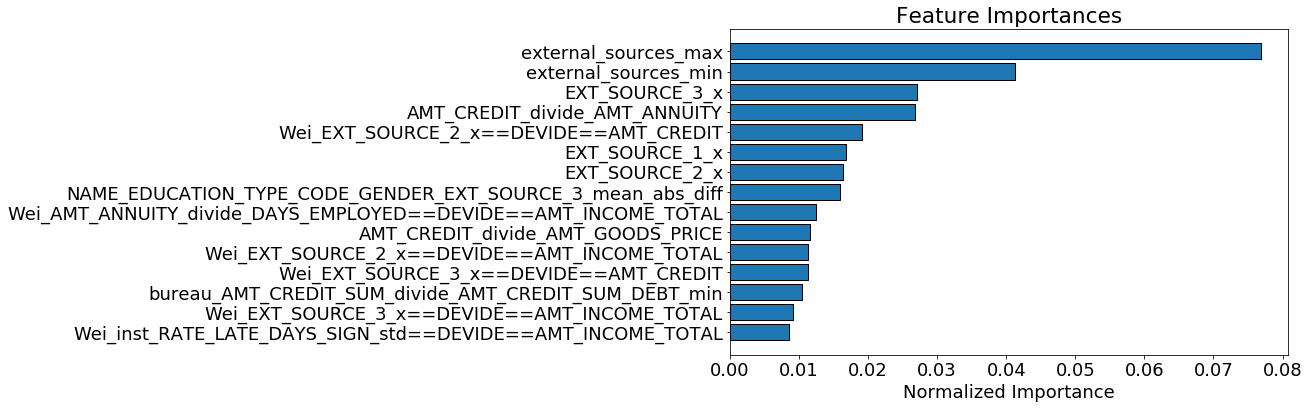

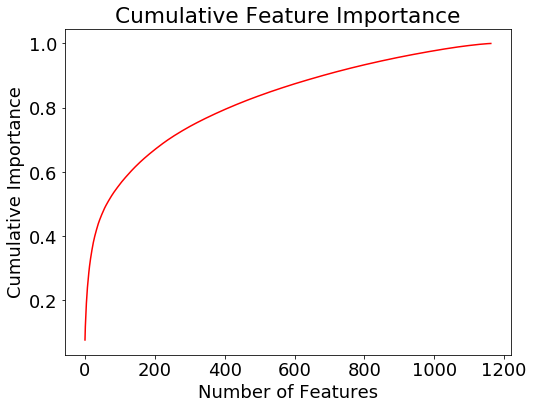

682 features required for 0.90 of cumulative importance


In [16]:
# feature_importances = pickle.load(open('../selection_comb_bo2_op5f4_simfe/fe_imp_corr_nan_df.pkl','rb'))
split_norm_fe_imp = plot_feature_importances(feature_importance_gain_df)

In [15]:
feature_importance_gain_df

,feature,importance
0,external_sources_max,27614.407749
1,external_sources_min,14808.069049
2,EXT_SOURCE_3_x,9737.886909
3,AMT_CREDIT_divide_AMT_ANNUITY,9586.603175
4,Wei_EXT_SOURCE_2_x==DEVIDE==AMT_CREDIT,6883.154045
5,EXT_SOURCE_1_x,6040.997813
6,EXT_SOURCE_2_x,5870.801360
7,NAME_EDUCATION_TYPE_CODE_GENDER_EXT_SOURCE_3_m...,5705.372708
8,Wei_AMT_ANNUITY_divide_DAYS_EMPLOYED==DEVIDE==...,4460.279870
9,AMT_CREDIT_divide_AMT_GOODS_PRICE,4166.032034


In [13]:
# feature_importances = pickle.load(open('../selection_comb_bo2_op5f4_simfe/fe_imp_corr_nan_df.pkl','rb'))
split_norm_fe_imp = plot_feature_importances(feature_importance_df)

NameError: name 'plot_feature_importances' is not defined